# Retinopathy Classification

## Submit result to kaggle as Part3 HW: https://www.kaggle.com/c/retinopathy-classification-sai

## HINT

1.   Select model from keras application
2.   Transfer learning
3.   Data Augmentation
4.   More imaage preprocess (ex: histogram equlization, crop image, ... etc)



In [130]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [131]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [132]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

#### Data Visualization

In [133]:
paths = glob('/gdrive/My Drive/AI_medical/Week4/retina-dataset/retina-train/*.jpeg')
paths_test = sorted(glob('/gdrive/My Drive/AI_medical/Week4/retina-dataset/retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

/gdrive/My Drive/AI_medical/Week4/retina-dataset/retina-train/19485_right_2.jpeg


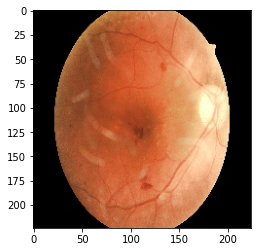

In [134]:
idx = np.random.randint(0, len(paths), size=1)[0]
path = paths[idx]
# path = 'retina-train/5258_right_2.jpeg'
img = cv2.imread(path)# [:,:,::-1]
plt.imshow(img[:,:,::-1])
print(path)

In [135]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])
all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['30570_left_2.jpeg', '30586_left_0.jpeg', '30602_right_0.jpeg']
[2, 0, 0]


<BarContainer object of 3 artists>

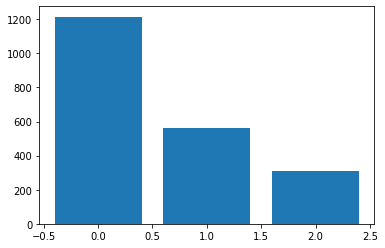

In [136]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Build Transfer Learning Model

In [137]:
# Build model
tf.keras.backend.clear_session()

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
predictions = layers.Dense(3, activation='softmax')(x)

for l in base_model.layers:
    l.trainable = False
model = models.Model(base_model.input, predictions)

In [138]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

#### Prepare Data

In [139]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [140]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        img = tf.keras.applications.efficientnet.preprocess_input(img) 
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes)
        return x_data, y_data
    else:
        return x_data

In [141]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:01<00:00, 314.20it/s]


In [142]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

#### Training

In [143]:
model.compile(optimizer='adam', 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [144]:
# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)

# Training
batch_size = 32
logs = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                 epochs=50,
                 steps_per_epoch=len(x_train) / batch_size,
                 validation_data=(x_val, y_val))

Epoch 1/50
52/52 [==============================] - 22s 327ms/step - loss: 1.0065 - categorical_accuracy: 0.5379 - val_loss: 0.8026 - val_categorical_accuracy: 0.6388
Epoch 2/50
52/52 [==============================] - 16s 302ms/step - loss: 0.8889 - categorical_accuracy: 0.5914 - val_loss: 0.7581 - val_categorical_accuracy: 0.6531
Epoch 3/50
52/52 [==============================] - 16s 302ms/step - loss: 0.8127 - categorical_accuracy: 0.6341 - val_loss: 0.7615 - val_categorical_accuracy: 0.6507
Epoch 4/50
52/52 [==============================] - 16s 299ms/step - loss: 0.8044 - categorical_accuracy: 0.6560 - val_loss: 0.7426 - val_categorical_accuracy: 0.6603
Epoch 5/50
52/52 [==============================] - 16s 302ms/step - loss: 0.7849 - categorical_accuracy: 0.6697 - val_loss: 0.7485 - val_categorical_accuracy: 0.6627
Epoch 6/50
52/52 [==============================] - 16s 301ms/step - loss: 0.7716 - categorical_accuracy: 0.6493 - val_loss: 0.7475 - val_categorical_accuracy: 0.660

#### Make Submission file

In [145]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,2
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,2
518,9673_right.jpeg,0
519,9690_left.jpeg,0
520,9717_right.jpeg,0


In [146]:
!cp submission.csv "/gdrive/My Drive/AI_medical/Week4/"

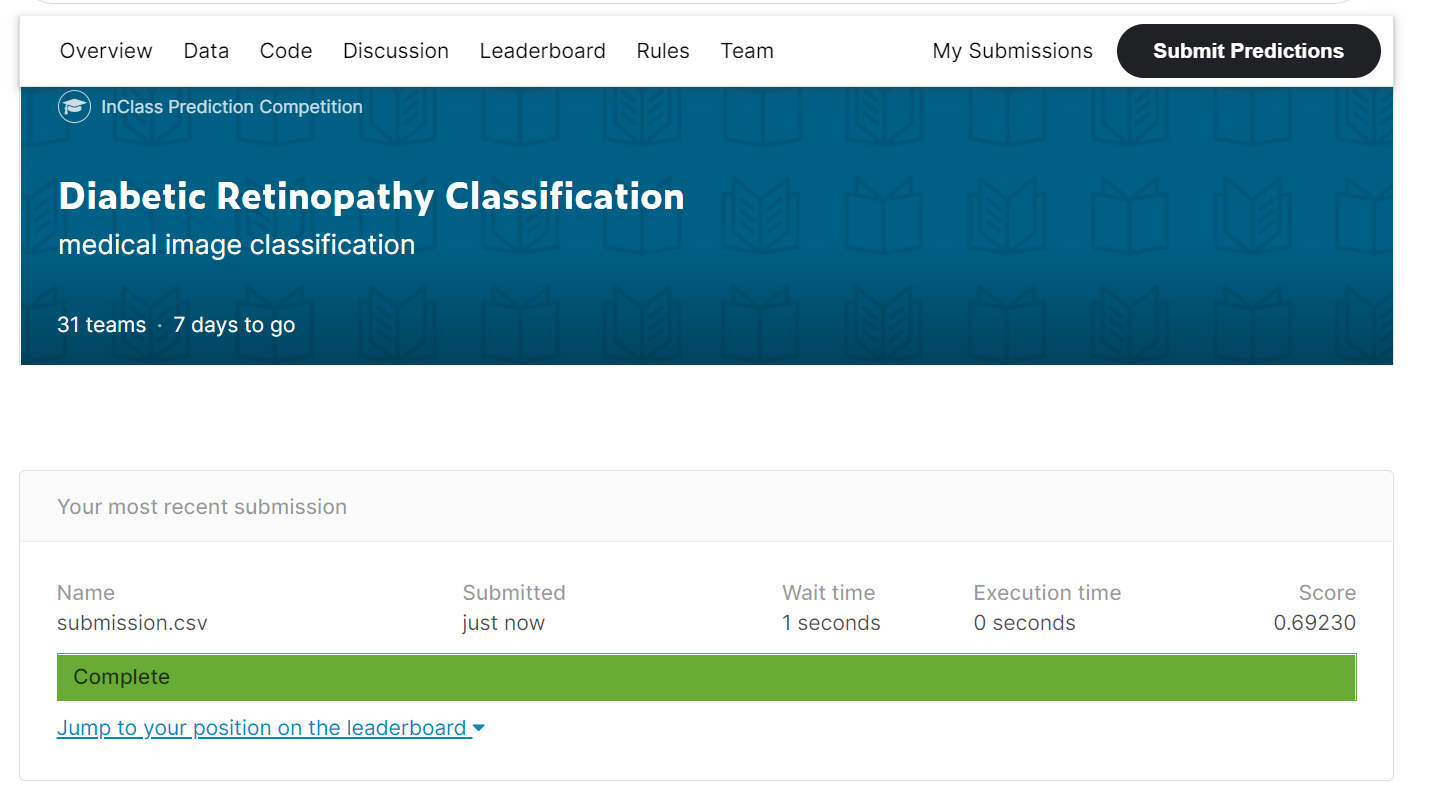

In [1]:
from IPython.display import Image
Image(filename='kaggle.png')